## 4 - Velocity Basics

In this notebook, we will explore how GPlately helps you obtain useful plate velocity data for feature and point data. 
In particular, we will look at:

- Plotting velocity vector fields easily using GPlately's `PlotTopologies` object
- Calculating plate velocity data of a feature;
- Assorted visualisations of velocity data
    - Streamplots
    - Scatterplots

GPlates uses EarthByte's Plate Tectonic Tools package to obtain velocity data. It simplifies the velocity calculation and plotting process for you!

To see this in action, let's first initialise all needed packages:

In [1]:
import gplately

import numpy as np
import pygplates
import ptt
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Before you can obtain velocity data, you need to set up a plate motion model. This can be easily done with GPlately's `PlateReconstruction` object - all you need to provide it is a pygplates rotation model, a set of pygplates feature topologies and a path to some static polygons.

In this notebook we will use the rotation model, static polygons and all active gpml features from the Muller et al. (2019) plate motion model.

In [2]:
# Parent directory for Muller et al. data
input_directory = 'Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/'

# Construct a pygplates rotation model
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

# Construct a topology feature collection using pygplates, making sure to exclude any inactive files
topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

# Initialise static polygons
static_polygons = input_directory+'StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp'

Now we can construct our plate motion model and use this in our GPlately `PlotTopologies` object!

In [3]:
# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Reconstruction time
time = 50 # Ma

# Define paths to geometry shapefiles
coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
COBs = input_directory+"StaticGeometries/COBLineSegments/Global_EarthByte_GeeK07_COBLineSegments_2019_v1.shp"

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

### Plotting velocity vector arrow fields
From here, plotting a plate velocity vector field is quite simple - all you need to do is create a GeoAxis map using matplotlib and Cartopy and call the `plot_plate_motion_vectors` method!

You can still pass quiver keyword arguments for presenting your vector field. In this case, we've used the regridding parameter, which is useful if you'd like your vectors interpolated onto a regular grid in projection space.

Underneath the vector field, we'll use GPlately to plot our geological shapefile features reconstructed to 50 Ma.

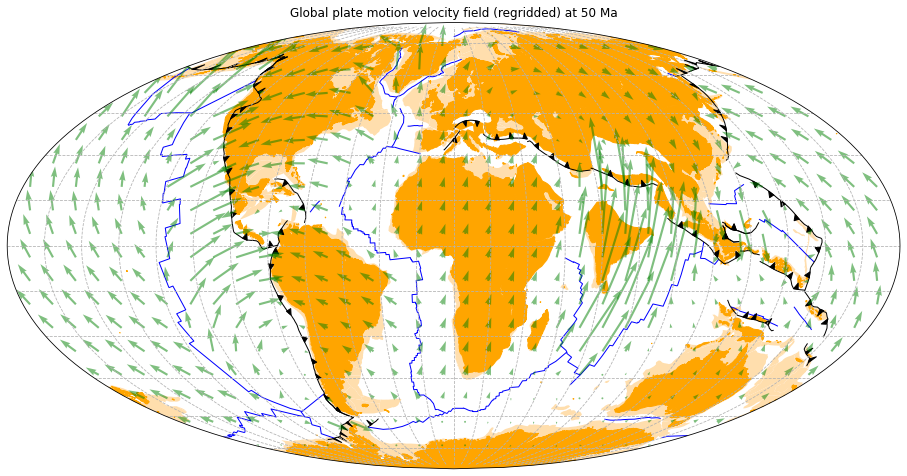

In [4]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax1.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity field (regridded) at %i Ma' % (time))

# Plot all topologies
gplot.plot_continents(ax1, facecolor='navajowhite')
gplot.plot_coastlines(ax1, color='orange')
gplot.plot_ridges_and_transforms(ax1, color='b')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')

# Plot a veloctiy vector field on both maps
gplot.plot_plate_motion_vectors(ax1, regrid_shape=20, alpha=0.5, color='green', zorder=2)

### Accessing the velocity data

The plot above was created from velocity data that was internally calculated by `plot_plate_motion_vectors` and not returned to us. If you want access to this velocity data to use it in other ways (ie. visualise them with matplotlib streamplots, scatterplots or contours), GPlately can calculate and return this to you too! 

We'll use `get_point_velocities`, which is a method in the `PlateReconstruction` object. It returns the north and east components of velocities for each point that we give it. To call this method, we'll need to use our plate motion model again.

To use this function you need to create two numpy arrays containing the latitude and longitude locations of points that you want to place in a velocity domain feature. You must next create a meshnode-type grid of feature points at these specified locations and flatten them into 1d arrays. These flattened lat-lon arrays are passed into `get_point_velocities`.

In [5]:
# Let's span our lat-lon arrays across the entire globe with 5-degree spacing
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Generate the meshnode point feature and flatten back into 1d lat-lon arrays
x,y = np.meshgrid(Xnodes,Ynodes)
x = x.flatten()
y = y.flatten()

# Call the GPlately function to get point velocities!
time = 50 # Ma
all_velocities = model.get_point_velocities(x, y, time, delta_time=1.0)

print('Our all_velocities data...')
print(all_velocities)
print('Number of points in our velocity domain = ', len(x))
print('Number of lists containing velocity data = ', len(all_velocities))

Our all_velocities data...
[[ -3.87083921  -1.89315628]
 [ -3.87083921  -1.89315628]
 [ -3.87083921  -1.89315628]
 ...
 [-27.25261405  20.46778238]
 [-29.15923534  18.01416028]
 [-30.84393725  15.4043343 ]]
Number of points in our velocity domain =  2592
Number of lists containing velocity data =  2592


As you can see above, `all_velocities` is a list containing several lists. Each internal list contains the north and east components of velocity for each point in our domain at the chosen reconstruction time (50 Ma in this case). 

We can calculate the magnitude of velocity in units of cm/yr. Let's do it for a random domain point:

In [6]:
chosen_pt = 326
vel_mag = np.hypot(all_velocities[chosen_pt][0], all_velocities[chosen_pt][1])
print('Average speed (cm/yr): ', vel_mag)

Average speed (cm/yr):  4.140850754834013


### Assorted representations of `all_velocities` data

You can visualise the data in `all_velocities` in many ways. Generally, we need to make four parameters. Let's call them x, y, u and v.

x and y are simply the velocity domain point coordinates (Xnodes and Ynodes as a meshnode grid), while the u and v velocity components are created from the north and east velocity components we just discussed.

In [7]:
# Extract the north and east velocity components and create u,v velocity components with them
pt_vel_n=[]
pt_vel_e=[]
for vel in all_velocities:
    pt_vel_e.append(vel[1])
    pt_vel_n.append(vel[0])
    
u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))

# Create x and y domain point coordinates
x, y = np.meshgrid(Xnodes,Ynodes)

### Example 1: Velocity streamplot

We can create a streamplot using all_velocities. Let's use matplotlib for the streamplot and GPlately's `PlateTopologies` object to reconstruct features to 50 Ma.

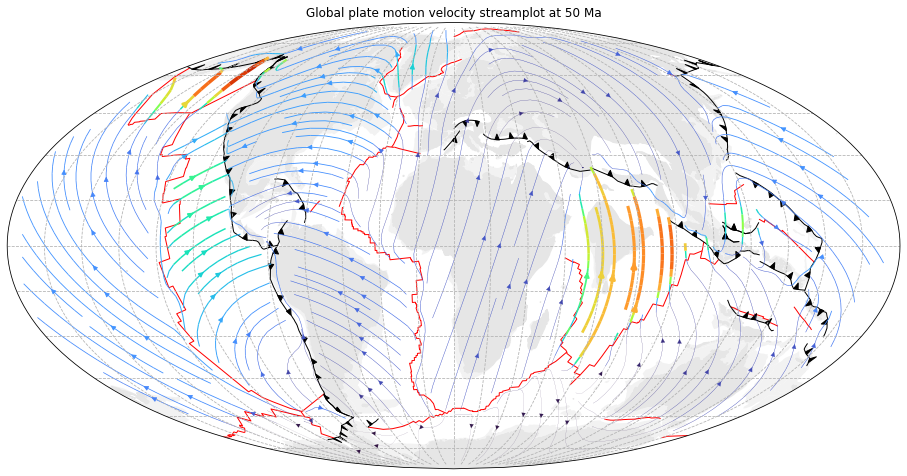

In [8]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

# Plot all topologies
gplot.time = 50 # Ma
gplot.plot_continents(ax2, facecolor='0.95')
gplot.plot_coastlines(ax2, color='0.9')
gplot.plot_ridges_and_transforms(ax2, color='r')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k')

# Create the streamplot, using speed as a colormap.
speed = np.sqrt(u**2 + v**2)
S = ax2.streamplot(Xnodes,Ynodes,u,v,color=speed, transform=ccrs.PlateCarree(), 
                   linewidth=0.02*speed, cmap=plt.cm.turbo, density=2)
plt.show()

If you have moviepy available, you can create a gif that illustrates these streamplot motions through geological time. Let's reconstruct plate movements over 100 Ma in intervals of 10 Ma. 

Note that for each run of the time loop, only the u and v components of velocity change. They rely on 'all_velocities', which is recalculated in each loop iteration using the command `all_velocities = model.get_point_velocities(x, y, time, delta_time=1.0)`. Underneath this command, the u and v components are recalculated.

The Xnodes and Ynodes remain the same with each iteration since they are just the locations of the domain points. Xnodes and Ynodes are still `x, y = np.meshgrid(Xnodes,Ynodes)` defined in the cells above. 

In [132]:
# Time variables
oldest_seed_time = 100 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    print(f'working on time {time}')
    
    # Calculate velocity data at this time
    all_velocities = model.get_point_velocities(x, y, time, delta_time=1.0)
    
    # Extract the north and east velocity components and create u,v velocity components with them
    pt_vel_n=[]
    pt_vel_e=[]
    for vel in all_velocities:
        pt_vel_e.append(vel[1])
        pt_vel_n.append(vel[0])

    u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
    v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(16,12))
    ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

    # Update gplot reconstruction time
    gplot.time = 50 # Ma
    
    # Plot all topologies
    gplot.plot_continents(ax2, facecolor='0.95')
    gplot.plot_coastlines(ax2, color='0.9')
    gplot.plot_ridges_and_transforms(ax2, color='r')
    gplot.plot_trenches(ax2, color='k')
    gplot.plot_subduction_teeth(ax2, color='k')

    # Create the streamplot, using speed as a colormap.
    speed = np.sqrt(u**2 + v**2)
    S = ax2.streamplot(Xnodes,Ynodes,u,v,color=speed, transform=ccrs.PlateCarree(), 
                       linewidth=0.02*speed, cmap=plt.cm.turbo, density=2)
    
    plt.savefig('/tmp/plate_velocity_stream_plot_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

working on time 100.0
Image for 100 Ma saved
working on time 90.0
Image for 90 Ma saved
working on time 80.0
Image for 80 Ma saved
working on time 70.0
Image for 70 Ma saved
working on time 60.0
Image for 60 Ma saved
working on time 50.0
Image for 50 Ma saved
working on time 40.0
Image for 40 Ma saved
working on time 30.0
Image for 30 Ma saved
working on time 20.0
Image for 20 Ma saved
working on time 10.0
Image for 10 Ma saved


In [133]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/plate_velocity_stream_plot_%d_Ma.png' % time)
    
clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/plate_velocity_stream_plot.gif')

t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]

MoviePy - Building file /tmp/plate_velocity_stream_plot.gif with imageio.


The movie will show up in a few seconds. Please be patient...


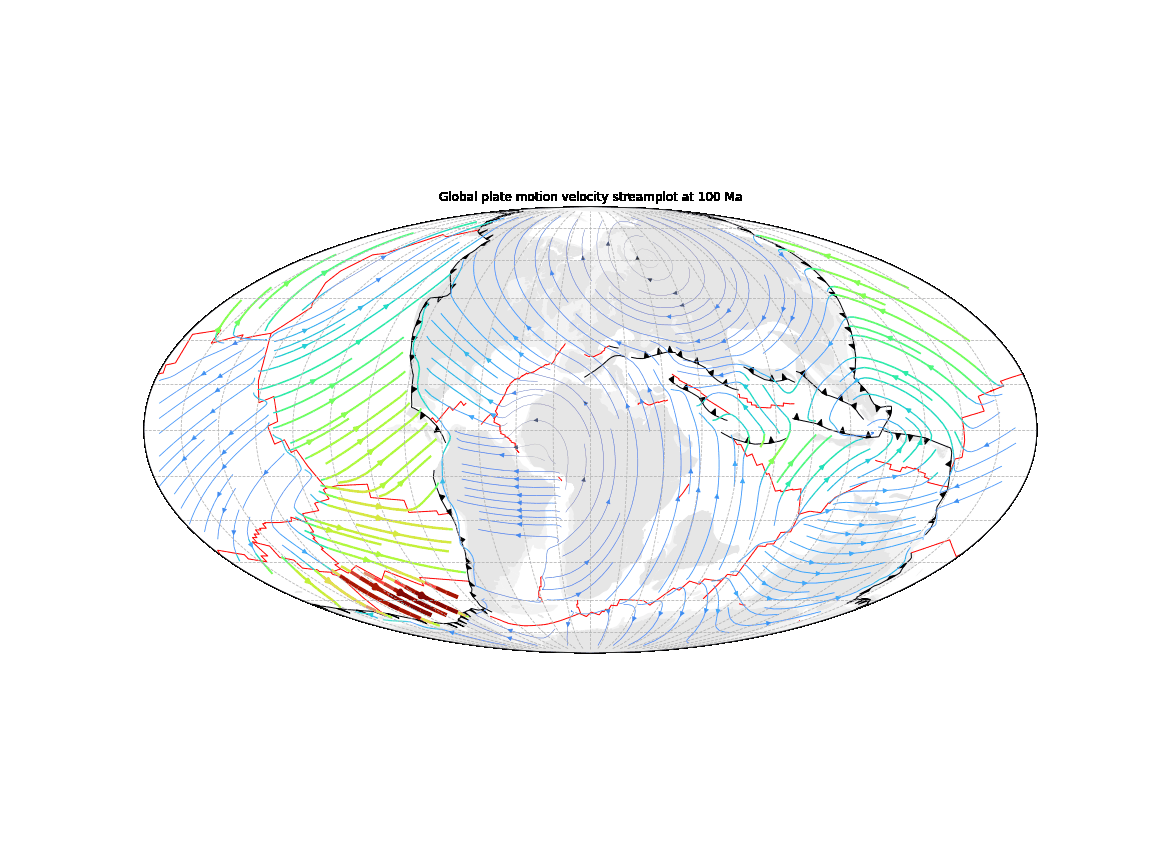

In [134]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/plate_velocity_stream_plot.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 3000, height = 1000))

### Example 2: Scatterplot

Representing velocity magnitudes on a scatterplot can be done by plotting each domain point and colour-coding them by velocity magnitude. 

All you need to start are 2 arrays: one for the latitiudes and another for the longitudes of the points you want in your domain point feature. You can use them to generate a mesh of velocity domain points. In this notebook, we do this by creating a multi-point (collection of points) on a sphere with pygplates. The x,y components of all point velocities can be calculated with GPlately's `model.get_point_velocities` method. Each velocity magnitude is obtained from the _hypotenuse_ of these x,y components.

In [9]:
# Longitude and latitude arrays; global extent with 5 degree intervals
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Create a lat-lon mesh and convert to 1d lat-lon arrays
lons,lats = np.meshgrid(Xnodes,Ynodes)
lons = lons.flatten()
lats = lats.flatten()

# Set a reconstruction time
time = 50 #ma

# Make velocity domain point feature (a mesh of points scattered across the global sphere) and extract each point's
# lat and lon coordinates
pointlat = []
pointlon = []
multi_point = pygplates.MultiPointOnSphere([(float(lat),float(lon)) for lat, lon in zip(lats,lons)]).to_lat_lon_point_list()
for each_point in multi_point:
    pointlat.append(each_point.get_latitude())
    pointlon.append(each_point.get_longitude())
    
# Use GPlately to calculate x,y velocity components
domain_pt_velocities = model.get_point_velocities(lons, lats, time)

# Obtain the magnitude of each point's velocity using these x,y components
pt_vel_mags = []
for vel in domain_pt_velocities:
    pt_vel_mags.append(np.hypot(vel[0], vel[1]))

We plot these domain points below using the list of point velocity magnitudes "pt_vel_mags" as a colour scale for our scatterplot colorbar.

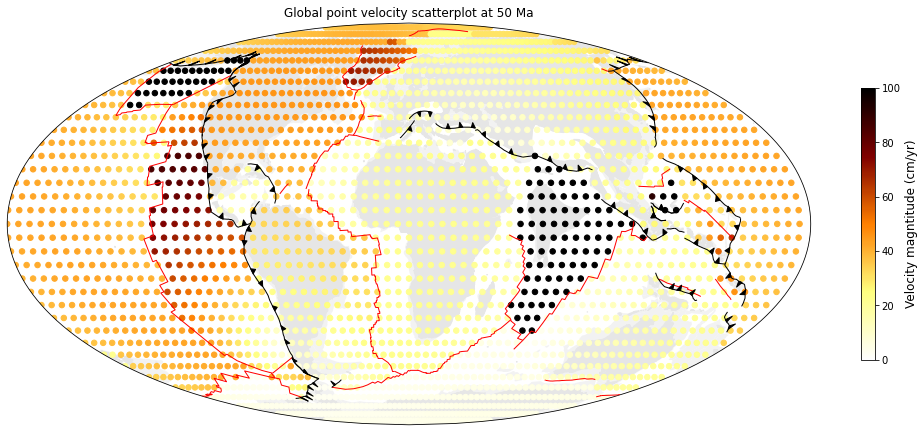

In [11]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(18,10))
ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
#ax3.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global point velocity scatterplot at %i Ma' % (time))

# Update gplot time attribute
gplot.time = 50 # Ma

# Plot all topologies
gplot.plot_continents(ax3, facecolor='0.95')
gplot.plot_coastlines(ax3, color='0.9')
gplot.plot_ridges_and_transforms(ax3, color='r', zorder=3)
gplot.plot_trenches(ax3, color='k', zorder=3)
gplot.plot_subduction_teeth(ax3, color='k', zorder=3)

# Plot the lat-lon point pairs onto the map using matplotlib. Specify a velocity magnitude colour scale.
im = ax3.scatter(pointlon, pointlat, transform=ccrs.PlateCarree(),c=pt_vel_mags,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=100, zorder=2)

# add colorbar, set global extent and show plot
fig.colorbar(im, ax=ax3,shrink=0.5).set_label('Velocity magntitude (cm/yr)',fontsize=12)
ax3.set_global()
plt.show()

If you have moviepy available, you can create a gif that illustrates average domain point velocities (cm/yr) over 100 Ma. Let's reconstruct plate movements in intervals of 10 Ma.

With each iteration of the time loop you'll need to re-calculate velocity data, but note that the domain point locations ('pointlon' and 'pointlat') remain the same.

In [13]:
# Time variables
oldest_seed_time = 100 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    print(f'working on time {time}')
    
    # Call the GPlately function to get point velocities; do this for each time interval
    domain_pt_velocities = model.get_point_velocities(lons, lats, time, delta_time=1.0) 
    
    # Calculate the magnitude of each point's velocities - we use the velocity data calculated with GPlately.
    pt_vel_mags = []
    for vel in domain_pt_velocities:
        pt_vel_mags.append(np.hypot(vel[0], vel[1]))
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,10))
    ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    #ax3.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Global point velocity scatterplot at %i Ma' % (time))

    # Update gplot time
    gplot.time = time

    # Plot all topologies
    gplot.plot_continents(ax3, facecolor='0.95')
    gplot.plot_coastlines(ax3, color='0.9')
    gplot.plot_ridges_and_transforms(ax3, color='r', zorder=3)
    gplot.plot_trenches(ax3, color='k', zorder=3)
    gplot.plot_subduction_teeth(ax3, color='k', zorder=3)

    # Plot the lat-lon point pairs onto the map using matplotlib
    im = ax3.scatter(pointlon, pointlat, transform=ccrs.PlateCarree(),c=pt_vel_mags,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=100, zorder=2)

    # add colorbar, set global extent and show plot
    fig.colorbar(im, ax=ax3,shrink=0.5).set_label('Velocity magntitude (cm/yr)',fontsize=12)
    ax3.set_global()
    
    plt.savefig('/tmp/plate_velocity_scatter_plot_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

working on time 100.0
Image for 100 Ma saved
working on time 90.0
Image for 90 Ma saved
working on time 80.0
Image for 80 Ma saved
working on time 70.0
Image for 70 Ma saved
working on time 60.0
Image for 60 Ma saved
working on time 50.0
Image for 50 Ma saved
working on time 40.0
Image for 40 Ma saved
working on time 30.0
Image for 30 Ma saved
working on time 20.0
Image for 20 Ma saved
working on time 10.0
Image for 10 Ma saved


In [14]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/plate_velocity_scatter_plot_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/plate_velocity_scatter_plot.gif')

t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]

MoviePy - Building file /tmp/plate_velocity_scatter_plot.gif with imageio.


The movie will show up in a few seconds. Please be patient...


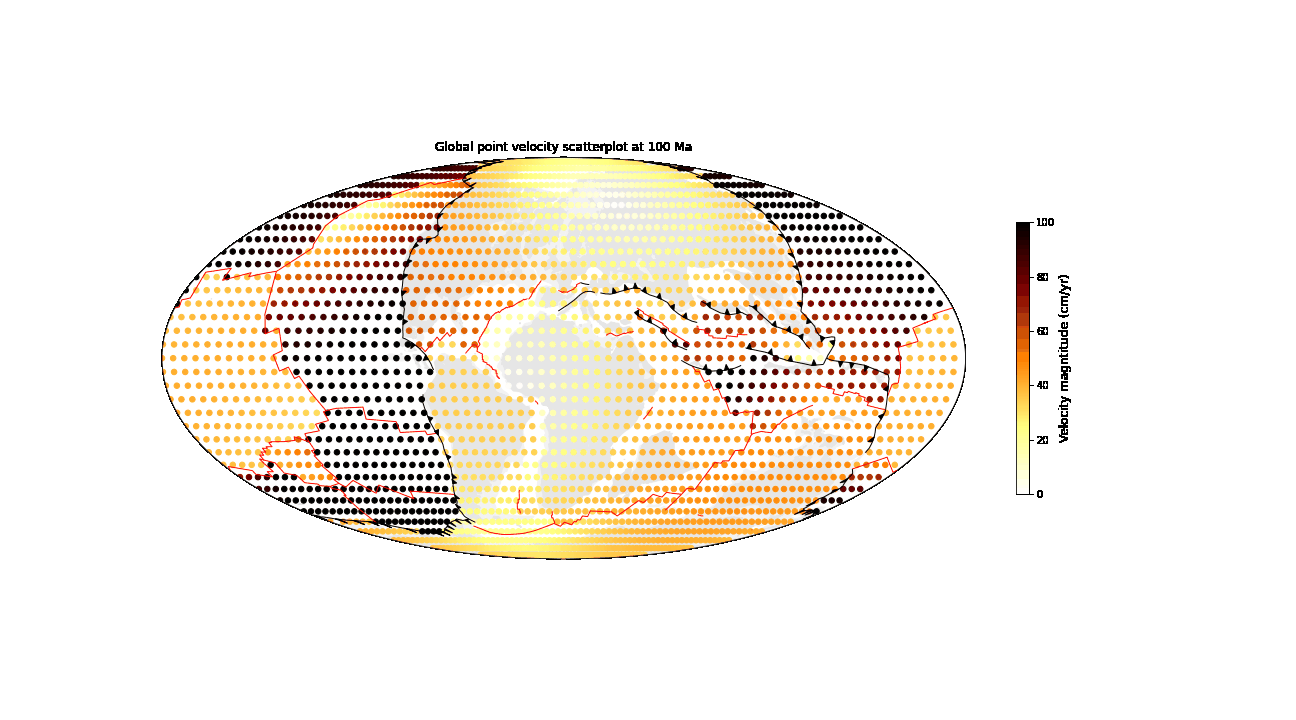

In [15]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/plate_velocity_scatter_plot.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 3000, height = 1000))